# Actor-Critic Training for Attack-Defense Tree Time Environment

## Training Process
1. Environment setup and configuration
2. Agent initialization with neural networks
3. Multi-agent training loop with episode collection
4. Performance monitoring and visualization
5. Model saving and evaluation

In [1]:
# Import Required Libraries
import numpy as np
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm.notebook import tqdm

# Import our custom modules
from adt_time_env import AttackDefenseTreeMultiAgentTimeEnv
from adt_actor_critic import ADTAgent, TrainingMetrics

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Consistent random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
# set device
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device_name = "cpu"
device = torch.device(device_name)
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu126
CUDA available: True
Using device: cpu


## Environment Setup and Configuration

First, let's create the multi-agent environment and examine its properties.

In [2]:
print("🌍 Setting up ADT Multi-Agent Environment...")

# Create environment directly without wrappers to avoid reset issues
env = AttackDefenseTreeMultiAgentTimeEnv("envs/adt_nuovo_env.json", render_mode=None)
print("✅ Environment created successfully!")

# Environment information
print(f"\n📊 Environment Information:")
print(f"Agents: {env.possible_agents}")
print(f"Action spaces: {env.action_spaces}")
print(f"Observation spaces: {env.observation_spaces}")

# Reset to get initial observations
obs, info = env.reset(seed=42)
print(f"\n🔍 Initial observation shapes:")
for agent, observation in obs.items():
    print(f"  {agent}: {observation.shape}")
print("✅ Environment reset working properly!")

# Get state and action dimensions
state_size = env.observation_spaces['attacker'].shape[0]
attacker_action_size = env.action_spaces['attacker'].n
defender_action_size = env.action_spaces['defender'].n

print(f"\n🧠 Network Dimensions:")
print(f"State size: {state_size}")
print(f"Attacker actions: {attacker_action_size}")
print(f"Defender actions: {defender_action_size}")
print(f"State variables: {env.state_vars}")
print(f"Number of state variables: {len(env.state_vars)}")

# Test a quick episode iteration
print(f"\n⚙️  Testing environment iteration...")
try:
    agent_count = 0
    for agent_name in env.agent_iter():
        agent_count += 1
        if agent_count > 2:  # Just test first 2 iterations
            break
        obs, reward, term, trunc, info = env.last()
        print(f"  Agent {agent_name}: obs shape {obs.shape}")
        env.step(0)  # Take a dummy action
    print("✅ Environment iteration working!")
except Exception as e:
    print(f"⚠️  Iteration warning: {e}")

🌍 Setting up ADT Multi-Agent Environment...
✅ Environment created successfully!

📊 Environment Information:
Agents: ['attacker', 'defender']
Action spaces: {'attacker': Discrete(7), 'defender': Discrete(8)}
Observation spaces: {'attacker': Box([ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1], [ 1  1  2  2  2  2  2  2  2  2  2  2  2 20 20], (15,), int32), 'defender': Box([ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1], [ 1  1  2  2  2  2  2  2  2  2  2  2  2 20 20], (15,), int32)}

🔍 Initial observation shapes:
  attacker: (15,)
  defender: (15,)
✅ Environment reset working properly!

🧠 Network Dimensions:
State size: 15
Attacker actions: 7
Defender actions: 8
State variables: ['DataExfiltration', 'current_player', 'AccesstoMySQL', 'AccesstoExecuteArbitraryCode', 'AccesstoReverseShell', 'AccesstoSensitiveFiles', 'WebReconSuccesful', 'UnencryptedFiles', 'SOCKS5ProxyActive', 'MisconfiguredApache', 'WebserverPubliclyExposed', 'CGIscriptsenabled', 'VulnerableApacheHTTPServerVersion', 'attacker

## Agent Initialization

Create the actor-critic agents for both attacker and defender with appropriate neural network architectures.

In [3]:
# Training hyperparameters
LEARNING_RATE = 3e-4 # Learning rate for the optimizer
GAMMA = 0.99 # Discount factor
HIDDEN_SIZE = 128 # Size of hidden layers in the neural networks
MAX_EPISODES = 5_000
UPDATE_FREQUENCY = 10  # Update policy every N episodes
PRINT_FREQUENCY = 100  # Print stats every N episodes

# Epsilon exploration parameters
EPSILON_START = 1.0  # Starting epsilon for exploration
EPSILON_END = 0.01   # Final epsilon for exploration  
EPSILON_DECAY = 5000 # Number of steps for epsilon decay

print("🤖 Initializing Actor-Critic Agents with Epsilon Exploration...")

# Create agents
attacker_agent = ADTAgent(
    state_size=state_size,
    action_size=attacker_action_size,
    agent_name='attacker',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

defender_agent = ADTAgent(
    state_size=state_size,
    action_size=defender_action_size,
    agent_name='defender',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

print(f"✅ Agents initialized with epsilon exploration!")
print(f"   Epsilon start: {EPSILON_START}")
print(f"   Epsilon end: {EPSILON_END}")
print(f"   Epsilon decay: {EPSILON_DECAY} steps")

# Initialize training metrics
metrics = TrainingMetrics()

print("📊 Model Summary:")
print("Attacker Agent:")
summary(attacker_agent.network, (state_size,), device=device_name)
print("Defender Agent:")
summary(defender_agent.network, (state_size,), device=device_name)

🤖 Initializing Actor-Critic Agents with Epsilon Exploration...
✅ Agents initialized with epsilon exploration!
   Epsilon start: 1.0
   Epsilon end: 0.01
   Epsilon decay: 5000 steps
📊 Model Summary:
Attacker Agent:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,048
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 7]             455
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
Total params: 35

## Training Helper Functions

Define utility functions for the training process.

In [4]:
def run_episode(env, attacker_agent, defender_agent, episode_num, max_steps=100):
    """
    Run episode with epsilon-greedy exploration enabled during training.
    """
    obs, info = env.reset()
    
    episode_data = {
        'attacker_reward': 0,
        'defender_reward': 0,
        'length': 0,
        'winner': None,
        'goal_achieved': False
    }
    
    # Track experiences for each agent separately
    agent_experiences = {
        'attacker': [],
        'defender': []
    }
    
    step_count = 0
    
    for agent_name in env.agent_iter():
        if step_count >= max_steps:
            break
            
        observation, reward, termination, truncation, info = env.last()
        episode_data[f'{agent_name}_reward'] += reward
        
        if termination or truncation:
            # Store final experience with terminal flag
            if step_count > 0 and agent_experiences[agent_name]:
                # Update last experience with final reward and terminal flag
                last_exp = agent_experiences[agent_name][-1]
                last_exp['reward'] = reward
                last_exp['done'] = True
            break
        
        step_count += 1
        episode_data['length'] = step_count
        
        available_actions = env.get_available_actions(agent_name)
        
        # Get action from appropriate agent (with epsilon exploration enabled)
        if agent_name == 'attacker':
            action, log_prob, value, _ = attacker_agent.get_action(
                observation.astype(np.float32), available_actions, deterministic=False
            )
        else:
            action, log_prob, value, _ = defender_agent.get_action(
                observation.astype(np.float32), available_actions, deterministic=False
            )
        
        # Store experience
        agent_experiences[agent_name].append({
            'state': observation.copy(),
            'action': action,
            'reward': 0,  # Will be updated with next iteration's reward
            'log_prob': log_prob,
            'value': value,
            'done': False
        })
        
        env.step(action)
    
    # Store all experiences in agent buffers
    for agent_name, experiences in agent_experiences.items():
        agent = attacker_agent if agent_name == 'attacker' else defender_agent
        for exp in experiences:
            agent.store_transition(
                state=exp['state'],
                action=exp['action'],
                reward=exp['reward'],
                log_prob=exp['log_prob'],
                value=exp['value'],
                done=exp['done']
            )
    
    episode_data['goal_achieved'] = env.goal_reached
    episode_data['winner'] = 'attacker' if episode_data['goal_achieved'] else 'defender'
    
    return episode_data


def print_training_stats(episode, metrics, attacker_agent, defender_agent, start_time):
    """Print training statistics including epsilon values."""
    current_time = time.time()
    elapsed_time = current_time - start_time
    
    # Get recent statistics
    recent_stats = metrics.get_recent_stats(window=100)
    
    print(f"\n{'='*80}")
    print(f"EPISODE {episode:4d} | Time: {elapsed_time/60:.1f}m")
    print(f"{'='*80}")
    
    if recent_stats:
        print(f"📊 Last 100 Episodes:")
        print(f"   🔥 Avg Attacker Reward: {recent_stats['avg_attacker_reward']:8.2f}")
        print(f"   🛡️ Avg Defender Reward: {recent_stats['avg_defender_reward']:8.2f}")
        print(f"   📏 Avg Episode Length:  {recent_stats['avg_episode_length']:8.2f} steps")
        print(f"   🏆 Attacker Win Rate:   {recent_stats['attacker_win_rate']:8.2%}")
        print(f"   🏆 Defender Win Rate:   {recent_stats['defender_win_rate']:8.2%}")
    
    # Show current epsilon values
    print(f"   🎯 Current Attacker ε:   {attacker_agent.get_epsilon():8.4f}")
    print(f"   🎯 Current Defender ε:   {defender_agent.get_epsilon():8.4f}")
    
    # Show recent losses if available
    if len(metrics.attacker_losses['total']) > 0:
        recent_att_loss = np.mean(metrics.attacker_losses['total'][-10:])
        recent_def_loss = np.mean(metrics.defender_losses['total'][-10:])
        print(f"   📉 Recent Attacker Loss: {recent_att_loss:8.4f}")
        print(f"   📉 Recent Defender Loss: {recent_def_loss:8.4f}")


# Create directories for saving models and metrics
os.makedirs('trained_models', exist_ok=True)
os.makedirs('training_logs', exist_ok=True)

print("✅ Training helper functions defined with epsilon exploration!")
print("📁 Directories created for saving models and logs")

✅ Training helper functions defined with epsilon exploration!
📁 Directories created for saving models and logs


## Main Training Loop

Execute the main training loop with experience collection and policy updates.

In [5]:
# Main Training Loop
print("🚀 Starting Actor-Critic Training!")
print("="*80)

# Clear any existing buffers to ensure clean start
attacker_agent.clear_episode_data()
defender_agent.clear_episode_data()

start_time = time.time()

for episode in tqdm(range(1, MAX_EPISODES + 1)):
    # Run episode and collect experience (with epsilon exploration)
    episode_data = run_episode(env, attacker_agent, defender_agent, episode)
    
    # Log episode data with current epsilon values
    metrics.log_episode(
        episode_data,
        attacker_epsilon=attacker_agent.get_epsilon(),
        defender_epsilon=defender_agent.get_epsilon()
    )
    
    # Update policies periodically
    if episode % UPDATE_FREQUENCY == 0:
        # Update attacker policy
        att_losses = attacker_agent.update_policy()
        if att_losses:
            metrics.log_losses('attacker', att_losses)
        
        # Update defender policy
        def_losses = defender_agent.update_policy()
        if def_losses:
            metrics.log_losses('defender', def_losses)
    
    # Print statistics including epsilon values
    if episode % PRINT_FREQUENCY == 0:
        print_training_stats(episode, metrics, attacker_agent, defender_agent, start_time)


# Save final models and metrics
print(f"\n💾 Saving final models and metrics...")
attacker_agent.save_model('trained_models/time_attacker_actor_critic.pth')
defender_agent.save_model('trained_models/time_defender_actor_critic.pth')
metrics.save_metrics('training_logs/time_training_metrics.pkl')

total_time = time.time() - start_time
print(f"✅ Training completed in {total_time/60:.1f} minutes!")
print(f"📊 Total episodes: {len(metrics.episode_lengths)}")

# Show final exploration statistics
print(f"\n🎯 FINAL EXPLORATION STATISTICS:")
print(f"Final Attacker Epsilon: {attacker_agent.get_epsilon():.6f}")
print(f"Final Defender Epsilon: {defender_agent.get_epsilon():.6f}")
print(f"Attacker steps taken: {attacker_agent.steps_done}")
print(f"Defender steps taken: {defender_agent.steps_done}")

🚀 Starting Actor-Critic Training!


  0%|          | 0/5000 [00:00<?, ?it/s]


EPISODE  100 | Time: 0.0m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -1269.50
   🛡️ Avg Defender Reward: -3839.00
   📏 Avg Episode Length:     25.63 steps
   🏆 Attacker Win Rate:     75.00%
   🏆 Defender Win Rate:     25.00%
   🎯 Current Attacker ε:     0.7691
   🎯 Current Defender ε:     0.7833
   📉 Recent Attacker Loss:   0.3781
   📉 Recent Defender Loss:   0.6519

EPISODE  200 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -1206.00
   🛡️ Avg Defender Reward: -4638.60
   📏 Avg Episode Length:     25.40 steps
   🏆 Attacker Win Rate:     90.00%
   🏆 Defender Win Rate:     10.00%
   🎯 Current Attacker ε:     0.5934
   🎯 Current Defender ε:     0.6154
   📉 Recent Attacker Loss:   0.3963
   📉 Recent Defender Loss:   0.4365

EPISODE  200 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -1206.00
   🛡️ Avg Defender Reward: -4638.60
   📏 Avg Episode Length:     25.40 steps
   🏆 Attacker Win Rate:     90.00%
   🏆 Defender Win Rate:     10.00%
   🎯 Current Attacker 

## Training Results Visualization

Analyze and visualize the training progress with comprehensive plots.

📊 Saving training metrics and generating visualizations...
Training metrics saved to training_logs/time_training_metrics.pkl
Training metrics loaded from training_logs/time_training_metrics.pkl
📊 Generating main training progress plot...


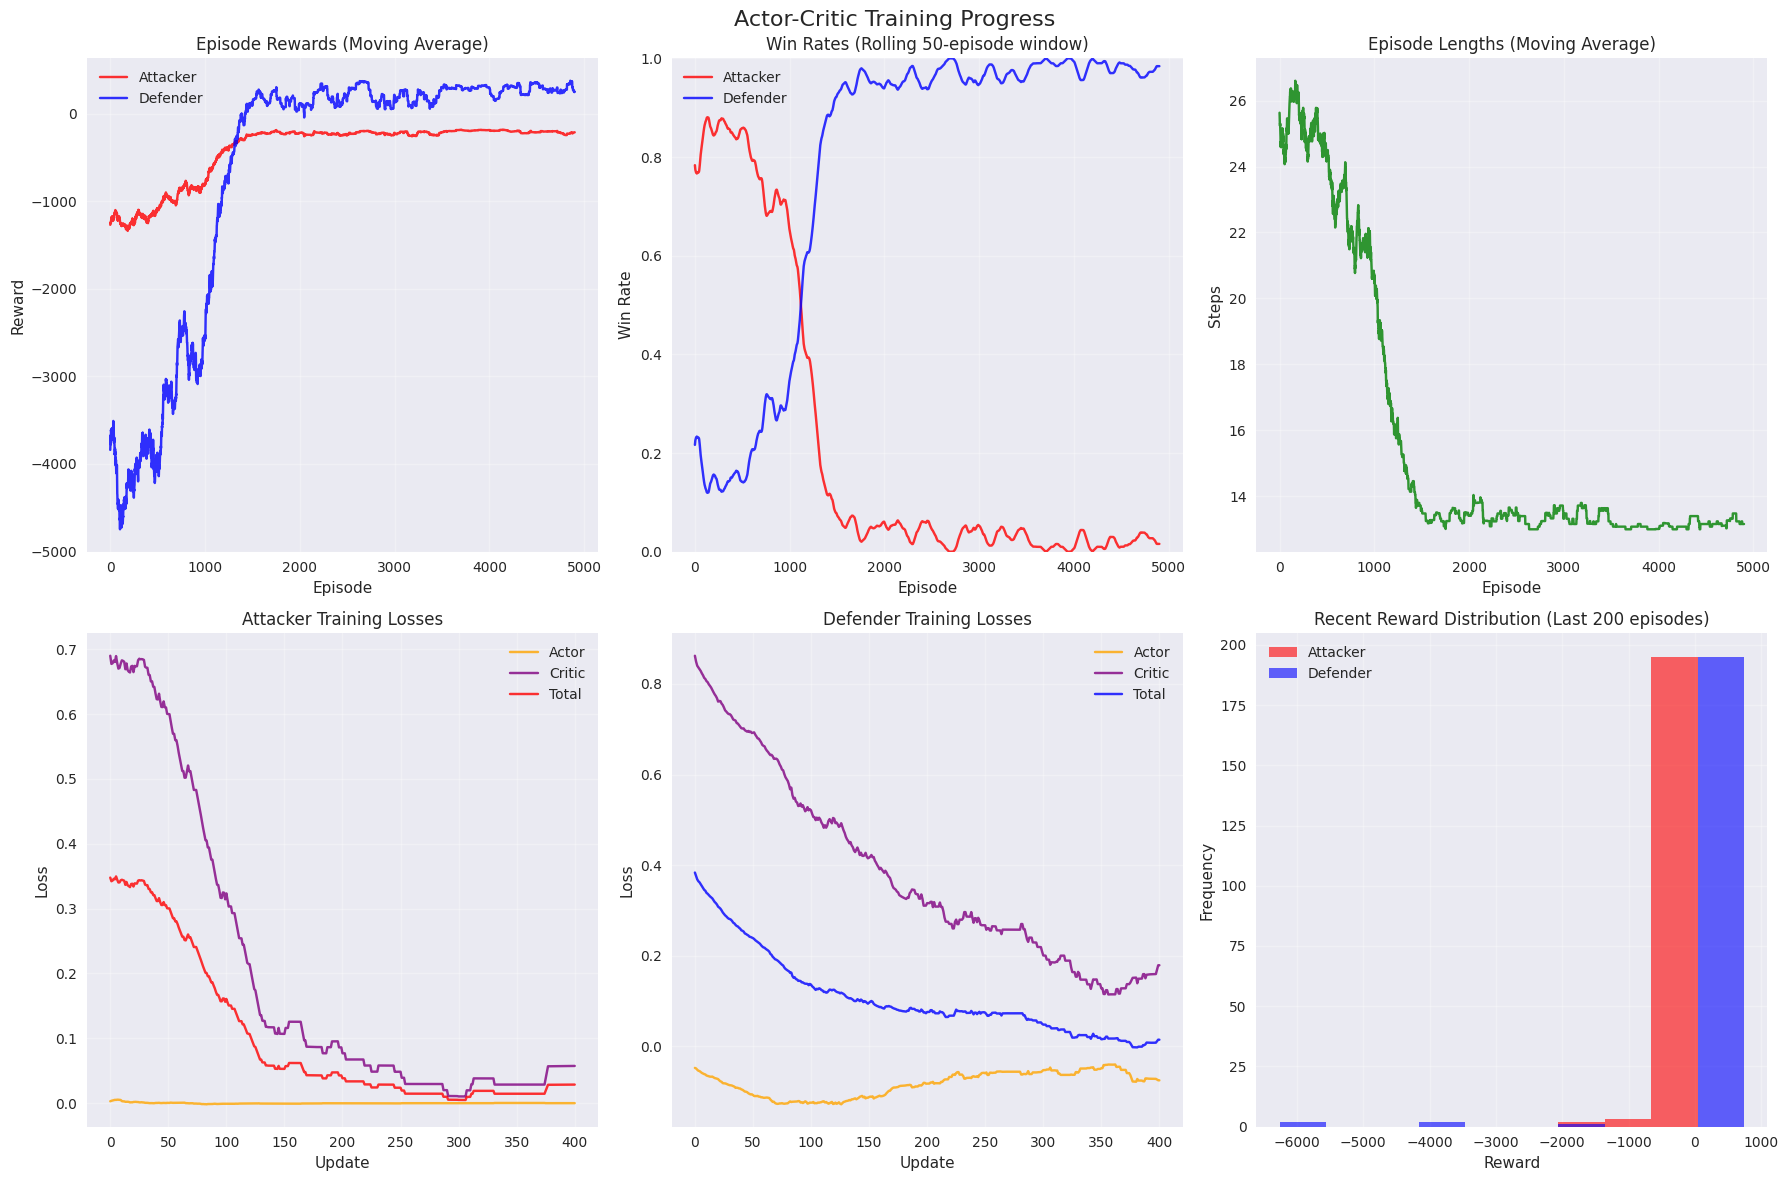

📊 Generating epsilon decay plot...


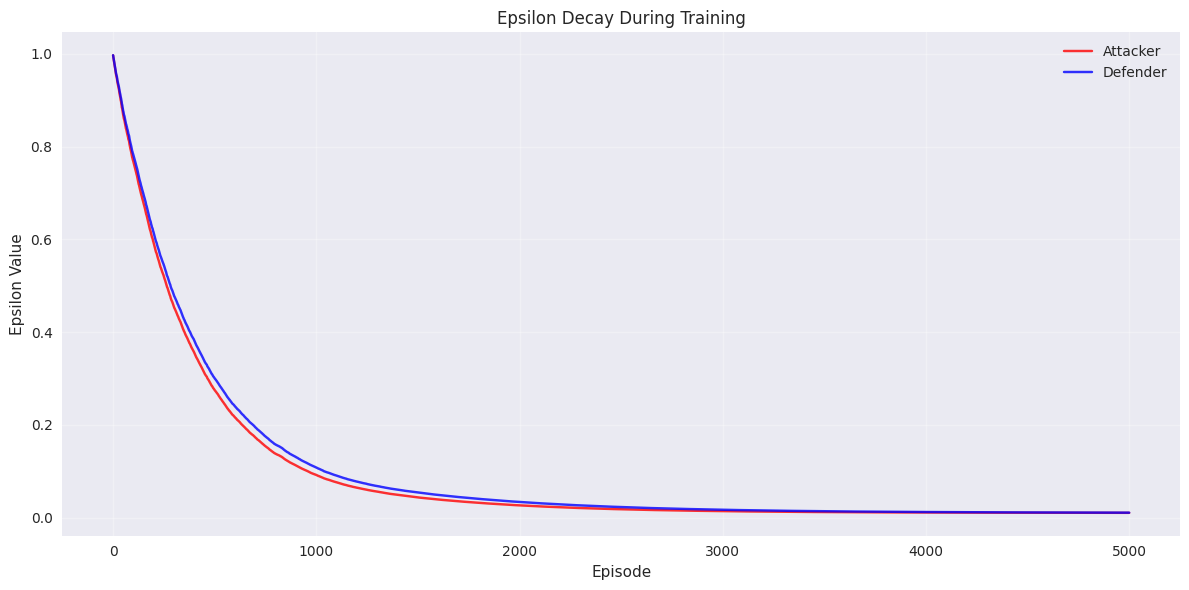

📊 Generating detailed reward comparison...


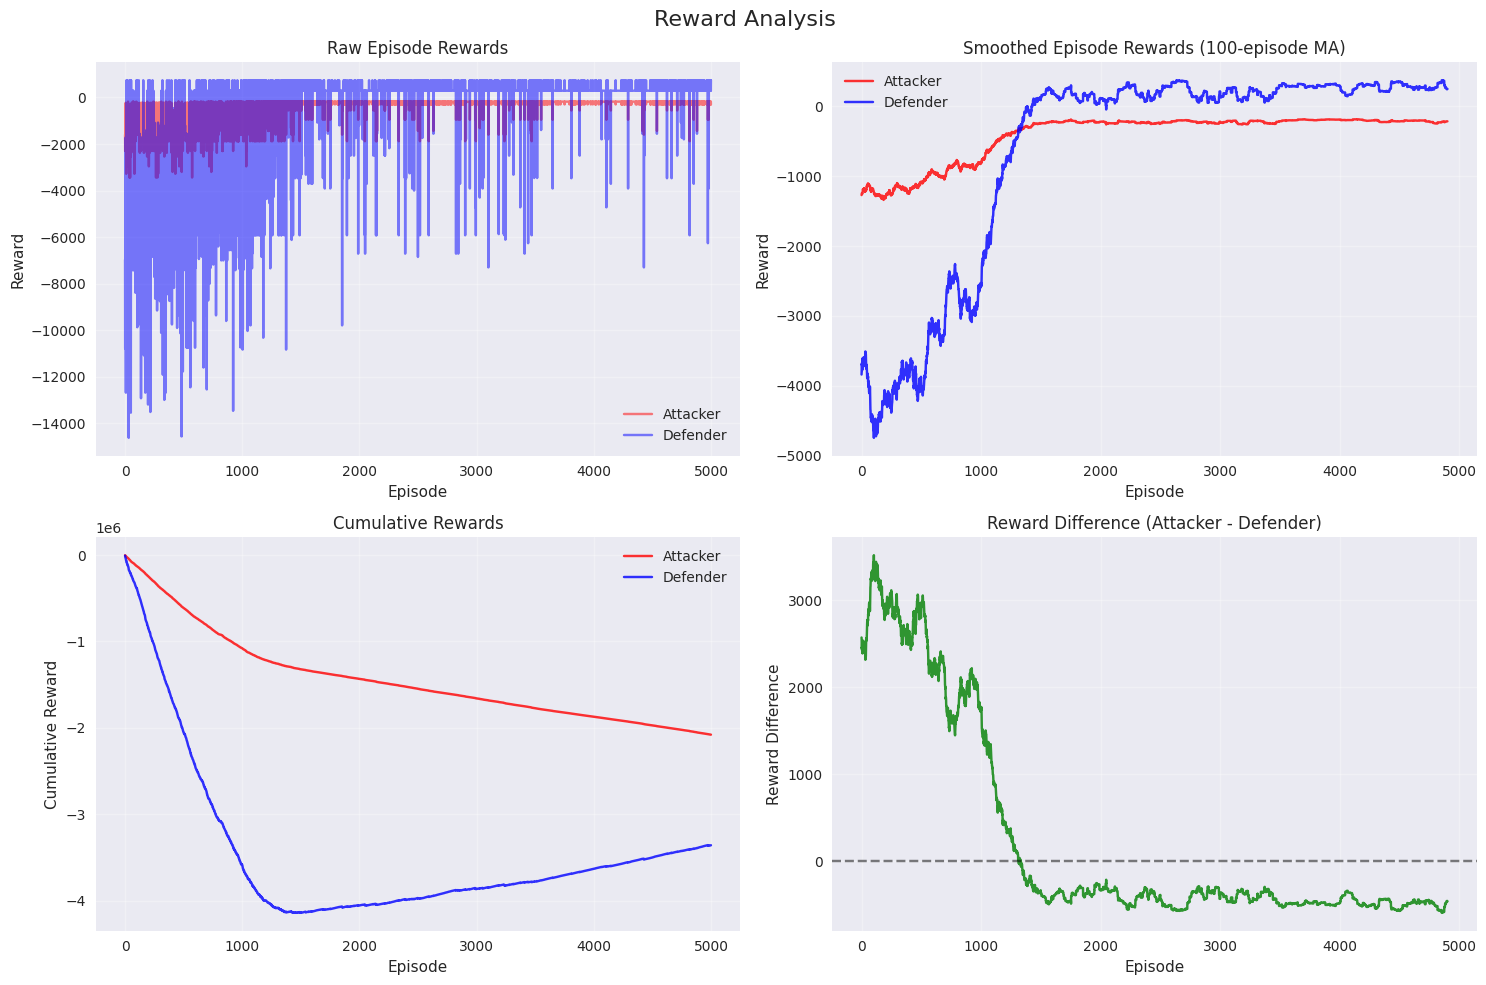


📈 FINAL TRAINING STATISTICS
Total Episodes Completed: 5000
Average Episode Length: 15.80 ± 6.22

🏆 FINAL PERFORMANCE (Last 200 episodes):
Attacker Win Rate: 2.50%
Defender Win Rate: 97.50%
Average Attacker Reward: -228.70
Average Defender Reward: 259.20
Average Episode Length: 13.32 steps

🎯 FINAL TRAINING LOSSES:
Attacker Final Loss: 0.0285
Defender Final Loss: 0.0090

📋 COMPREHENSIVE TRAINING SUMMARY:
TRAINING SUMMARY
Total Episodes: 5000
Average Episode Length: 15.80 ± 6.22

REWARDS:
  Attacker - Mean: -415.892, Std: 505.050
  Defender - Mean: -671.946, Std: 2234.589

WIN RATES:
  Attacker: 21.7%
  Defender: 78.3%

RECENT PERFORMANCE (Last 100 episodes):
  Attacker - Mean Reward: -213.600
  Defender - Mean Reward: 250.000
  Attacker Win Rate: 2.0%
  Defender Win Rate: 98.0%


In [6]:
# Save training metrics and generate plots using the new plotting system
print("📊 Saving training metrics and generating visualizations...")

# Save metrics to file first
metrics.save_metrics('training_logs/time_training_metrics.pkl')

# Now use the separate plotting utility to generate visualizations
from plot_training_metrics import TrainingPlotter

# Create plotter instance
plotter = TrainingPlotter('training_logs/time_training_metrics.pkl')

# Generate comprehensive training progress plot
print("📊 Generating main training progress plot...")
plotter.plot_training_progress(
    save_path='training_logs/time_training_progress.png',
    show_plot=True
)

# Generate epsilon decay plot if epsilon data is available
print("📊 Generating epsilon decay plot...")
plotter.plot_epsilon_decay(
    save_path='training_logs/time_epsilon_decay.png',
    show_plot=True
)

# Generate detailed reward comparison
print("📊 Generating detailed reward comparison...")
plotter.plot_reward_comparison(
    save_path='training_logs/time_reward_comparison.png',
    show_plot=True
)

# Additional analysis using the metrics data directly
print(f"\n📈 FINAL TRAINING STATISTICS")
print(f"="*50)

total_episodes = len(metrics.episode_lengths)

# Overall statistics
print(f"Total Episodes Completed: {total_episodes}")
print(f"Average Episode Length: {np.mean(metrics.episode_lengths):.2f} ± {np.std(metrics.episode_lengths):.2f}")

# Final performance (last 200 episodes)
final_window = min(200, total_episodes)
final_stats = metrics.get_recent_stats(final_window)

print(f"\n🏆 FINAL PERFORMANCE (Last {final_window} episodes):")
print(f"Attacker Win Rate: {final_stats['attacker_win_rate']:.2%}")
print(f"Defender Win Rate: {final_stats['defender_win_rate']:.2%}")
print(f"Average Attacker Reward: {final_stats['avg_attacker_reward']:.2f}")
print(f"Average Defender Reward: {final_stats['avg_defender_reward']:.2f}")
print(f"Average Episode Length: {final_stats['avg_episode_length']:.2f} steps")

# Training stability analysis
if len(metrics.attacker_losses['total']) > 10:
    recent_att_loss = np.mean(metrics.attacker_losses['total'][-50:])
    recent_def_loss = np.mean(metrics.defender_losses['total'][-50:])
    print(f"\n🎯 FINAL TRAINING LOSSES:")
    print(f"Attacker Final Loss: {recent_att_loss:.4f}")
    print(f"Defender Final Loss: {recent_def_loss:.4f}")

# Print comprehensive summary
print(f"\n📋 COMPREHENSIVE TRAINING SUMMARY:")
plotter.print_training_summary()

## Model Testing and Evaluation

Test the trained models with a few evaluation games to verify performance.

In [7]:
# Test the trained models
print("🧪 Testing Trained Models")
print("="*50)

def test_trained_models(n_test_games=10):
    """Test the trained models with deterministic policies."""
    print(f"Running {n_test_games} test games with trained models...")
    
    test_results = {
        'attacker_rewards': [],
        'defender_rewards': [],
        'episode_lengths': [],
        'winners': []
    }
    
    for game in range(n_test_games):
        # Handle environment reset with proper error handling
        obs, info = env.reset()
        
        game_rewards = {'attacker': 0, 'defender': 0}
        step_count = 0
        
        for agent_name in env.agent_iter():
            if step_count > 50:  # Max steps limit
                break
                
            observation, reward, termination, truncation, info = env.last()
            game_rewards[agent_name] += reward
            
            if termination or truncation:
                env.step(None)
                break
            
            step_count += 1
            # Get available actions
            try:
                available_actions = env.get_available_actions(agent_name)
            except:
                # If method doesn't exist, use all actions
                if agent_name == 'attacker':
                    available_actions = list(range(6))
                else:
                    available_actions = list(range(7))
            
            if not available_actions:
                env.step(0)
                continue
            
            # Get deterministic action from trained agent
            if agent_name == 'attacker':
                action, _, _, _ = attacker_agent.get_action(observation, available_actions, deterministic=True)
            else:
                action, _, _, _ = defender_agent.get_action(observation, available_actions, deterministic=True)
            
            env.step(action)
        
        # Store results
        test_results['attacker_rewards'].append(game_rewards['attacker'])
        test_results['defender_rewards'].append(game_rewards['defender'])
        test_results['episode_lengths'].append(step_count)
        
        # if goal reached then the winner is the attacker
        if env.goal_reached:
            test_results['winners'].append('attacker')
        else:
            test_results['winners'].append('defender')
            
        print(f"Game {game+1:2d}: Att {game_rewards['attacker']:6.1f} | "
              f"Def {game_rewards['defender']:6.1f} | "
              f"Length: {step_count:2d} | "
              f"Winner: {test_results['winners'][-1]}")
    
    return test_results

# Run test games
test_results = test_trained_models(10)

# Analyze test results
print(f"\n🎯 TEST RESULTS SUMMARY:")
print(f"="*30)
print(f"Average Attacker Reward: {np.mean(test_results['attacker_rewards']):.2f}")
print(f"Average Defender Reward: {np.mean(test_results['defender_rewards']):.2f}")
print(f"Average Episode Length: {np.mean(test_results['episode_lengths']):.2f} steps")

attacker_wins = test_results['winners'].count('attacker')
defender_wins = test_results['winners'].count('defender')  
ties = test_results['winners'].count('tie')

print(f"Attacker Wins: {attacker_wins}/{len(test_results['winners'])} ({attacker_wins/len(test_results['winners']):.1%})")
print(f"Defender Wins: {defender_wins}/{len(test_results['winners'])} ({defender_wins/len(test_results['winners']):.1%})")
print(f"Ties: {ties}/{len(test_results['winners'])} ({ties/len(test_results['winners']):.1%})")

print(f"\n✅ Model testing complete!")

🧪 Testing Trained Models
Running 10 test games with trained models...
Game  1: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  2: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  3: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  4: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  5: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  6: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  7: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  8: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game  9: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender
Game 10: Att -180.0 | Def  290.0 | Length: 13 | Winner: defender

🎯 TEST RESULTS SUMMARY:
Average Attacker Reward: -180.00
Average Defender Reward: 290.00
Average Episode Length: 13.00 steps
Attacker Wins: 0/10 (0.0%)
Defender Wins: 10/10 (100.0%)
Ties: 0/10 (0.0%)

✅ Model testing complete!


In [8]:
def show_test_game(env, attacker_agent, defender_agent, max_steps=50):
    """Run and visualize a single test game with detailed step-by-step information."""
    
    obs, info = env.reset()

    print("\n🎮 GAME START")
    print("="*50)
    print(f"Initial state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    print(f"Goal: {env.goal}")
    print(f"Initial goal state: {env.state.get(env.goal, 'Not in state')}")
    
    step_count = 0
    total_rewards = {'attacker': 0, 'defender': 0}
    
    for agent_name in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        step_count += 1
        
        # Print step information
        print(f"\n⏱️  STEP {step_count} | Agent: {agent_name}")
        print(f"   Observation: {observation}")
        print(f"   Reward: {reward}")
        print(f"   Goal state: {env.state.get(env.goal, 'Not in state')}")
        # Get available actions
        available_actions = env.get_available_actions(agent_name)
        print(f"   Available actions: {available_actions}")
        
        total_rewards[agent_name] += reward
        
        # Get action from appropriate agent
        if agent_name == 'attacker':
            action, _, _, action_probs = attacker_agent.get_action(observation, available_actions, deterministic=True)
            print(f"   🔴 Attacker chose action: {env.get_action_name(action, agent_name)}")
        else:
            action, _, _, action_probs = defender_agent.get_action(observation, available_actions, deterministic=True)
            print(f"   🔵 Defender chose action: {env.get_action_name(action, agent_name)}")

        # Take action
        env.step(action)
        
        # Print current cumulative rewards
        print(f"   Cumulative rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
        
        if termination or truncation or step_count >= max_steps:
            print(f"   ⚠️  Game terminated: {termination}, truncated: {truncation}")
            break
        
        # Print state after action if available
        if hasattr(env, 'state'):
            print(f"   New state: {env.state}")
        

    
    # Game summary
    print("\n🏁 GAME SUMMARY")
    print("="*50)
    print(f"Game ended after {step_count} steps.")
    print(f"Final state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    print(f"Final goal state: {env.state.get(env.goal, 'Not in state')}")
    
    # Determine winner based on final state
    final_goal_achieved = False
    if env.goal in env.state and env.state[env.goal] == 1:
        final_goal_achieved = True

    if final_goal_achieved:
        print("🎯 Attacker successfully achieved the goal!")
        winner = "attacker"
    else:
        print("🛡️ Defender successfully prevented the attack!")
        winner = "defender"
    
    print(f"Winner: {winner}")
    print(f"Final rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
    
show_test_game(env, attacker_agent, defender_agent)


🎮 GAME START
Initial state: {'DataExfiltration': 0, 'current_player': 0, 'AccesstoMySQL': 0, 'AccesstoExecuteArbitraryCode': 0, 'AccesstoReverseShell': 0, 'AccesstoSensitiveFiles': 0, 'WebReconSuccesful': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPServerVersion': 1}
Goal: DataExfiltration
Initial goal state: 0

⏱️  STEP 1 | Agent: attacker
   Observation: [ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1]
   Reward: 0
   Goal state: 0
   Available actions: [5]
   🔴 Attacker chose action: webRecon
   Cumulative rewards: Attacker: 0, Defender: 0
   New state: {'DataExfiltration': 0, 'current_player': 0, 'AccesstoMySQL': 0, 'AccesstoExecuteArbitraryCode': 0, 'AccesstoReverseShell': 0, 'AccesstoSensitiveFiles': 0, 'WebReconSuccesful': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPS